In [1]:
import pandas as pd
import os

# Path to the directory and CSV file using os.path.join for OS independence
base_dir = os.path.join('..', 'data', 'raw')
recordings_dir = os.path.join(base_dir, 'recordings')
csv_file_path = os.path.join(base_dir, 'overview-of-recordings.csv')

# Reading the CSV file with error handling
try:
    data = pd.read_csv(csv_file_path)
    data = data[['phrase','prompt']]
except FileNotFoundError:
    print("CSV file not found at the specified path. Please check the path and try again.")
except pd.errors.EmptyDataError:
    print("CSV file is empty. Please check the file content.")
except pd.errors.ParserError:
    print("Error parsing CSV. Please check the CSV format.")

In [2]:
data.head()

,phrase,prompt
0,When I remember her I feel down,Emotional pain
1,When I carry heavy things I feel like breaking...,Hair falling out
2,there is too much pain when i move my arm,Heart hurts
3,My son had his lip pierced and it is swollen a...,Infected wound
4,My muscles in my lower back are aching,Infected wound


In [3]:
#Number of classes
num_classes = len(data['prompt'].unique())
print(f"Number of classes: {num_classes}")

Number of classes: 25


In [4]:
# Get max len of the phrases
max_len = data['phrase'].str.len().max()
print(f"Max length of the phrases: {max_len}")

Max length of the phrases: 155


In [5]:
# Calculate the frequency of each class
class_distribution = data['prompt'].value_counts()

# Calculate the percentage of each class
class_percentage = data['prompt'].value_counts(normalize=True) * 100

print("Class Distribution:\n", class_distribution)
print("\nClass Percentage:\n", class_percentage)

Class Distribution:
 prompt
Acne                  328
Shoulder pain         320
Joint pain            318
Infected wound        306
Knee pain             305
Cough                 293
Feeling dizzy         283
Muscle pain           282
Heart hurts           273
Ear ache              270
Hair falling out      264
Head ache             263
Feeling cold          263
Skin issue            262
Stomach ache          261
Back pain             259
Neck pain             251
Internal pain         248
Blurry vision         246
Body feels weak       241
Hard to breath        233
Emotional pain        231
Injury from sports    230
Foot ache             223
Open wound            208
Name: count, dtype: int64

Class Percentage:
 prompt
Acne                  4.924186
Shoulder pain         4.804083
Joint pain            4.774058
Infected wound        4.593905
Knee pain             4.578892
Cough                 4.398739
Feeling dizzy         4.248611
Muscle pain           4.233599
Heart hurts          

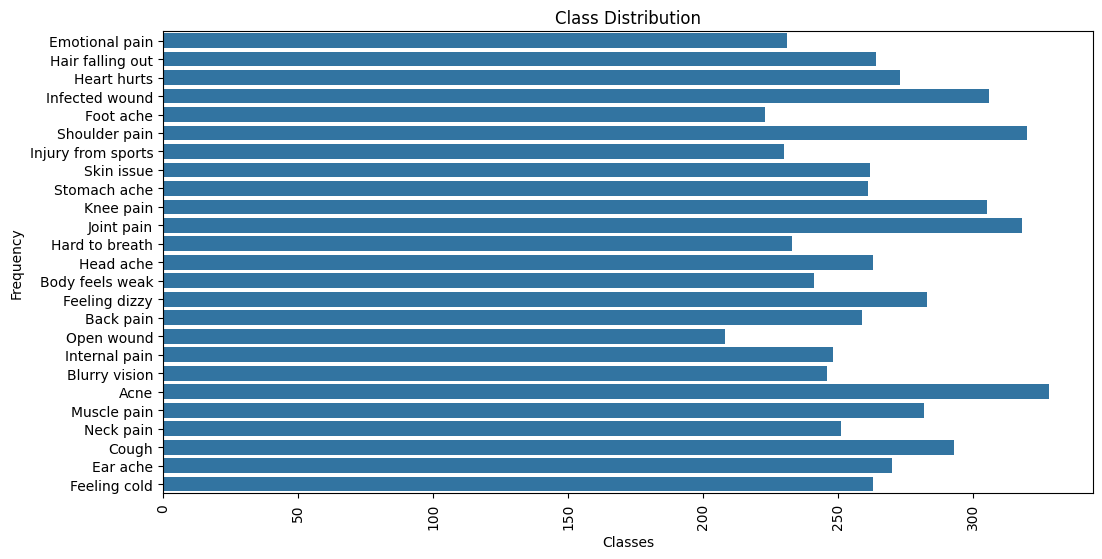

In [6]:
# Visualize the class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data['prompt'])
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

In [7]:
from transformers import BertTokenizer
from torch.utils.data import DataLoader, Dataset
import torch

class TextDataset(Dataset):
    def __init__(self, phrases, prompts, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = phrases
        self.labels = {label: idx for idx, label in enumerate(set(prompts))}
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        label = self.labels[self.text[item]]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        return {
            'review_text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [10]:
# Define dataset class
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_token_len=128):
        self.tokenizer = tokenizer
        self.texts = texts
        self.labels = labels
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )

        return {
            'input_ids': torch.tensor(encoding['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(encoding['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

# Map labels to integers
label_dict = {label: i for i, label in enumerate(data['prompt'].unique())}
data['labels'] = data['prompt'].map(label_dict)

print("Label Dictionary:", label_dict)

# Create dataset
dataset = TextClassificationDataset(
    texts=data['phrase'].to_list(),
    labels=data['labels'].to_list(),
    tokenizer=tokenizer,
    max_token_len=155
)

# Create train and test dataloaders

from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Label Dictionary: {'Emotional pain': 0, 'Hair falling out': 1, 'Heart hurts': 2, 'Infected wound': 3, 'Foot ache': 4, 'Shoulder pain': 5, 'Injury from sports': 6, 'Skin issue': 7, 'Stomach ache': 8, 'Knee pain': 9, 'Joint pain': 10, 'Hard to breath': 11, 'Head ache': 12, 'Body feels weak': 13, 'Feeling dizzy': 14, 'Back pain': 15, 'Open wound': 16, 'Internal pain': 17, 'Blurry vision': 18, 'Acne': 19, 'Muscle pain': 20, 'Neck pain': 21, 'Cough': 22, 'Ear ache': 23, 'Feeling cold': 24}


In [11]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=2e-5)

# Total number of training steps is the number of batches * number of epochs
total_steps = len(train_loader) * 3  # Training for 3 epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=total_steps)


C:\Users\paris\AppData\Roaming\Python\Python311\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
from tqdm import tqdm  # for displaying progress bar

# Function to calculate the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import numpy as np

# Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for epoch in range(3):  # loop over the dataset multiple times
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Epoch {:}".format(epoch + 1)):
        batch = {k: v.to(device) for k, v in batch.items()}  # Move batch to GPU

        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # prevent exploding gradient problem

        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_loader)
    loss_values.append(avg_train_loss)
    
    print(f"Epoch {epoch + 1} finished. Avg Loss: {avg_train_loss}")

    # Validation step
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps = 0

    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():    
            outputs = model(**batch)

        logits = outputs.logits
        labels_ids = batch['labels'].detach().cpu().numpy()
        tmp_eval_accuracy = flat_accuracy(logits.detach().cpu().numpy(), labels_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print(f"Test Accuracy: {eval_accuracy/nb_eval_steps}")


Epoch 1: 100%|██████████| 333/333 [00:21<00:00, 15.58it/s]


Epoch 1 finished. Avg Loss: 2.0502879644657397
Test Accuracy: 0.9449404761904762


Epoch 2: 100%|██████████| 333/333 [00:21<00:00, 15.65it/s]


Epoch 2 finished. Avg Loss: 0.3913399880757561
Test Accuracy: 0.9918154761904762


Epoch 3: 100%|██████████| 333/333 [00:21<00:00, 15.67it/s]


Epoch 3 finished. Avg Loss: 0.11766616190160001
Test Accuracy: 0.9933035714285714


In [13]:
# Save the entire model
torch.save(model, 'bert_model_full.pth')